In [1]:
# EDA
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn import preprocessing

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Content Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Collaborative Based Filtering
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# To work with text data
import re
import string

In [2]:
df = pd.read_csv('rec.csv')
df.head()


,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,4,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


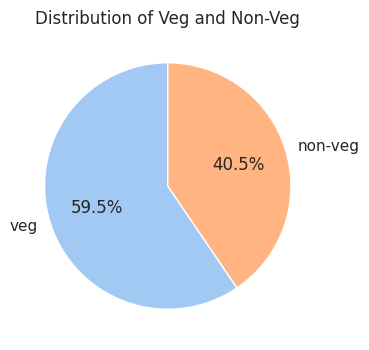

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme()


veg_non_counts = df['Veg_Non'].value_counts()


plt.figure(figsize=(4, 4))
plt.pie(veg_non_counts, labels=veg_non_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Veg and Non-Veg')
plt.show()

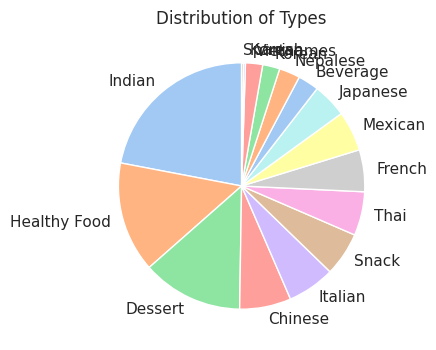

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme()


veg_non_counts = df['C_Type'].value_counts()


plt.figure(figsize=(4, 4))
plt.pie(veg_non_counts, labels=veg_non_counts.index,  startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Types')
plt.show()

In [3]:

len(list(df['Name'].unique()))

400

In [4]:
df['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai', 'Korean',
       ' Korean', 'Vietnames', 'Nepalese', 'Spanish'], dtype=object)

In [5]:
df['Veg_Non'].unique()

array(['veg', 'non-veg'], dtype=object)

In [6]:
len(df)

400

In [7]:
df.shape

(400, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


In [9]:

def text_cleaning(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    return text

In [10]:

df['Describe'] = df['Describe'].apply(text_cleaning)

In [11]:
df.head()

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,white balsamic vinegar lemon juice lemon rind ...
1,2,chicken minced salad,Healthy Food,non-veg,olive oil chicken mince garlic minced onion sa...
2,3,sweet chilli almonds,Snack,veg,almonds whole egg white curry leaves salt suga...
3,4,tricolour salad,Healthy Food,veg,vinegar honeysugar soy sauce salt garlic clove...
4,5,christmas cake,Dessert,veg,christmas dry fruits presoaked orange zest lem...


In [12]:

df.duplicated().sum()

0

In [13]:
df.isnull().sum()

Food_ID     0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64

In [14]:
df.describe()

,Food_ID
count,400.000000
mean,200.500000
std,115.614301
min,1.000000
25%,100.750000
50%,200.500000
75%,300.250000
max,400.000000


In [15]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Describe'])
tfidf_matrix.shape

(400, 1261)

In [16]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.16228366, 0.13001124, ..., 0.1286286 , 0.04277223,
        0.09993639],
       [0.16228366, 1.        , 0.06799336, ..., 0.14878001, 0.05688681,
        0.16917639],
       [0.13001124, 0.06799336, 1.        , ..., 0.03291577, 0.11795401,
        0.01834168],
       ...,
       [0.1286286 , 0.14878001, 0.03291577, ..., 1.        , 0.        ,
        0.10087579],
       [0.04277223, 0.05688681, 0.11795401, ..., 0.        , 1.        ,
        0.        ],
       [0.09993639, 0.16917639, 0.01834168, ..., 0.10087579, 0.        ,
        1.        ]])

In [17]:
indices = pd.Series(df.index, index=df['Name']).drop_duplicates()
indices

Name
summer squash salad                                          0
chicken minced salad                                         1
sweet chilli almonds                                         2
tricolour salad                                              3
christmas cake                                               4
                                                          ... 
Kimchi Toast                                               395
Tacos de Gobernador (Shrimp, Poblano, and Cheese Tacos)    396
Melted Broccoli Pasta With Capers and Anchovies            397
Lemon-Ginger Cake with Pistachios                          398
Rosemary Roasted Vegetables                                399
Length: 400, dtype: int64

In [18]:
def get_recommendations(title, cosine_sim=cosine_sim):

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar food
    sim_scores = sim_scores[1:6]

    food_indices = [i[0] for i in sim_scores]
    return df['Name'].iloc[food_indices]

In [19]:
features = ['C_Type','Veg_Non', 'Describe']

In [20]:
def create_soup(x):
    return x['C_Type'] + " " + x['Veg_Non'] + " " + x['Describe']

In [21]:
df['soup'] = df.apply(create_soup, axis=1)

In [22]:
df.head()

,Food_ID,Name,C_Type,Veg_Non,Describe,soup
0,1,summer squash salad,Healthy Food,veg,white balsamic vinegar lemon juice lemon rind ...,Healthy Food veg white balsamic vinegar lemon ...
1,2,chicken minced salad,Healthy Food,non-veg,olive oil chicken mince garlic minced onion sa...,Healthy Food non-veg olive oil chicken mince g...
2,3,sweet chilli almonds,Snack,veg,almonds whole egg white curry leaves salt suga...,Snack veg almonds whole egg white curry leaves...
3,4,tricolour salad,Healthy Food,veg,vinegar honeysugar soy sauce salt garlic clove...,Healthy Food veg vinegar honeysugar soy sauce ...
4,5,christmas cake,Dessert,veg,christmas dry fruits presoaked orange zest lem...,Dessert veg christmas dry fruits presoaked ora...


In [23]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [24]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [25]:
df = df.reset_index()
indices = pd.Series(df.index, index=df['Name'])

In [26]:
display(indices)

Name
summer squash salad                                          0
chicken minced salad                                         1
sweet chilli almonds                                         2
tricolour salad                                              3
christmas cake                                               4
                                                          ... 
Kimchi Toast                                               395
Tacos de Gobernador (Shrimp, Poblano, and Cheese Tacos)    396
Melted Broccoli Pasta With Capers and Anchovies            397
Lemon-Ginger Cake with Pistachios                          398
Rosemary Roasted Vegetables                                399
Length: 400, dtype: int64

In [27]:
get_recommendations('tricolour salad')

103             chilli chicken
1         chicken minced salad
27     vegetable som tam salad
282          veg hakka noodles
166             veg fried rice
Name: Name, dtype: object

In [28]:
get_recommendations('tricolour salad', cosine_sim2)

1                         chicken minced salad
103                             chilli chicken
27                     vegetable som tam salad
177                        oats shallots pulao
69     shepherds salad (tamatar-kheera salaad)
Name: Name, dtype: object

In [29]:
rating = pd.read_csv('ratings.csv')
rating.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


In [30]:
rating.shape

(512, 3)

In [31]:
rating.isnull().sum()

User_ID    1
Food_ID    1
Rating     1
dtype: int64

In [32]:
rating.tail()

,User_ID,Food_ID,Rating
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0
511,NaN,NaN,NaN


In [33]:
rating = rating[:511]
rating.tail()

,User_ID,Food_ID,Rating
506,99.0,65.0,7.0
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


In [34]:
rating.isnull().sum()

User_ID    0
Food_ID    0
Rating     0
dtype: int64

In [35]:
food_rating = rating.groupby(by = 'Food_ID').count()
food_rating = food_rating['Rating'].reset_index().rename(columns={'Rating':'Rating_count'})
food_rating

,Food_ID,Rating_count
0,1.0,2
1,2.0,3
2,3.0,2
3,4.0,2
4,5.0,6
...,...,...
304,305.0,1
305,306.0,1
306,307.0,1
307,308.0,1


In [36]:
food_rating['Rating_count'].describe()

count    309.000000
mean       1.653722
std        1.107748
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: Rating_count, dtype: float64

In [37]:
user_rating = rating.groupby(by='User_ID').count()
user_rating = user_rating['Rating'].reset_index().rename(columns={'Rating':'Rating_count'})
user_rating

,User_ID,Rating_count
0,1.0,4
1,2.0,4
2,3.0,9
3,4.0,6
4,5.0,6
...,...,...
95,96.0,6
96,97.0,7
97,98.0,7
98,99.0,6


In [38]:
user_rating["Rating_count"].describe()

count    100.000000
mean       5.110000
std        2.352282
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       11.000000
Name: Rating_count, dtype: float64

In [39]:
rating_matrix = rating.pivot_table(index='Food_ID',columns='User_ID',values='Rating').fillna(0)
rating_matrix.head()

User_ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
Food_ID,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0


In [40]:
rating_matrix.shape

(309, 100)

In [41]:
csr_rating_matrix =  csr_matrix(rating_matrix.values)
print(csr_rating_matrix)

  (0, 48)	5.0
  (0, 70)	10.0
  (1, 8)	3.0
  (1, 21)	5.0
  (1, 38)	10.0
  (2, 76)	1.0
  (2, 88)	7.0
  (3, 40)	6.0
  (3, 89)	6.0
  (4, 27)	10.0
  (4, 38)	10.0
  (4, 72)	7.0
  (4, 87)	3.0
  (4, 93)	2.0
  (4, 97)	7.0
  (5, 42)	10.0
  (5, 48)	6.0
  (5, 76)	6.0
  (5, 91)	1.0
  (6, 16)	4.0
  (6, 47)	5.0
  (6, 62)	9.0
  (6, 69)	8.0
  (6, 70)	8.0
  (7, 4)	6.0
  :	:
  (284, 30)	9.0
  (285, 80)	6.0
  (286, 24)	3.0
  (287, 54)	3.0
  (288, 55)	9.0
  (289, 31)	7.0
  (290, 15)	1.0
  (291, 2)	8.0
  (292, 95)	5.0
  (293, 41)	4.0
  (294, 43)	10.0
  (295, 41)	10.0
  (296, 94)	5.0
  (297, 55)	4.0
  (298, 2)	1.0
  (299, 28)	9.0
  (300, 53)	1.0
  (301, 77)	5.0
  (302, 63)	6.0
  (303, 29)	1.0
  (304, 55)	9.0
  (305, 79)	8.0
  (306, 70)	1.0
  (307, 96)	3.0
  (308, 31)	5.0


In [42]:
recommender = NearestNeighbors(metric='cosine')
recommender.fit(csr_rating_matrix)

NearestNeighbors(metric='cosine')

In [43]:
def Get_Recommendations(title):
    user= df[df['Name']==title]
    user_index = np.where(rating_matrix.index==int(user['Food_ID']))[0][0]
    user_ratings = rating_matrix.iloc[user_index]

    reshaped = user_ratings.values.reshape(1,-1)
    distances, indices = recommender.kneighbors(reshaped,n_neighbors=16)

    nearest_neighbors_indices = rating_matrix.iloc[indices[0]].index[1:]
    nearest_neighbors = pd.DataFrame({'Food_ID': nearest_neighbors_indices})

    result = pd.merge(nearest_neighbors,df,on='Food_ID',how='left')

    return result.head()

In [44]:
Get_Recommendations('tricolour salad')

,Food_ID,index,Name,C_Type,Veg_Non,Describe,soup
0,126.0,125,andhra crab meat masala,Indian,non-veg,processed crab meat refined oil curry leaves g...,Indian non-veg processed crab meat refined oil...
1,75.0,74,detox haldi tea,Beverage,veg,haldi ginger black pepper honey water,Beverage veg haldi ginger black pepper honey w...
2,100.0,99,spicy chicken curry,Indian,non-veg,oil ghee onion paste garlic paste ginger paste...,Indian non-veg oil ghee onion paste garlic pas...
3,259.0,258,ragi coconut ladoo (laddu),Dessert,veg,finger millet flour ragi jaggery peanuts cocon...,Dessert veg finger millet flour ragi jaggery p...
4,51.0,50,christmas chocolate fudge cookies,Dessert,veg,unsalted butter brown sugar chocolate chocolat...,Dessert veg unsalted butter brown sugar chocol...
